# Elo Merchant Category Recommendation - Proportion of restaurants <a class="tocSkip">
*End date: 2019. february 19.*

This tutorial notebook is the first part of a seriers for [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest organized by Elo, one of the largest payment brands in Brazil. It has built partnerships with merchants in order to offer promotions or discounts to cardholders. The objective of the competition is to identify and serve the most relevant opportunities to individuals, by uncovering signals in customer loyalty. The input files are available from the [download](https://www.kaggle.com/c/elo-merchant-category-recommendation/data) section of the contest:

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and testing
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

We will try to find out the proportion of merchants that are restaurants. The restaurantes must have a special daily behabiour, where most of their transactions are concentrated in the lunch and dinner hours (and maybe breakfast for coffee shops).

In [1]:
import os
import gc
import math
import scipy
import random
import warnings
import datetime
import calendar
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib.mlab import normpdf
from IPython.core.display import display, HTML
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.gofplots import qqplot

warnings.filterwarnings("ignore")

random.seed(1)

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [77]:
df_merch = pd.read_csv("input/merchants.csv")
df_merch = reduce_mem_usage(df_merch)
df_merch.head()

Starting memory usage: 56.18 MB
Reduced memory usage: 30.32 MB (46.0% reduction)


,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057465,-0.057465,N,E,E,-0.400000,...,-2.250000,18.666667,6,-2.320000,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057465,-0.057465,N,E,E,-0.720000,...,-0.740000,1.291667,6,-0.570000,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057465,-0.057465,N,E,E,-82.129997,...,-82.129997,260.000000,2,-82.129997,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057465,-0.057465,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057465,-0.057465,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [5]:
df_hist_trans = pd.read_csv("input/historical_transactions.csv")
df_hist_trans = reduce_mem_usage(df_hist_trans)
df_new_trans = pd.read_csv("input/new_merchant_transactions.csv")
df_new_trans = reduce_mem_usage(df_new_trans)

Starting memory usage: 3109.54 MB
Reduced memory usage: 1749.11 MB (43.7% reduction)
Starting memory usage: 209.67 MB
Reduced memory usage: 114.20 MB (45.5% reduction)


In [7]:
df_trans = pd.concat([df_hist_trans, df_new_trans]).reset_index()
df_trans.head()

,index,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


We will compute the ratio between the transactions performed in the ranges 12:00-15:00 and 19:00-22:00 and the total amount of transactions. The merchants with a ratio close to 1 may be restaurants. We could later check if their daily behavior is what one would expect. 

Just a quick check to ensure that the purchase_time is in the local Brazilian time zone (and not in Londonn time zone, for example)

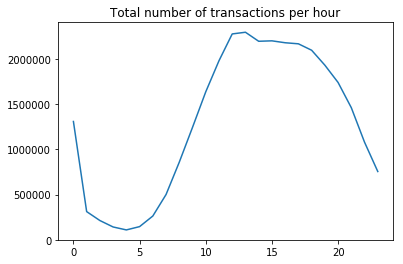

In [136]:
plt.plot(df_trans.groupby('purchase_hour').size())
plt.title("Total number of transactions per hour")
plt.show()

In [10]:
def extract_time_features(df, source_column, preposition):
    df[preposition + '_hour'] = df[source_column].dt.hour
    df[preposition + '_dayofweek'] = df[source_column].dt.dayofweek
    return df

df_trans['purchase_date'] = pd.to_datetime(df_trans['purchase_date'])
df_trans = extract_time_features(df_trans, 'purchase_date', 'purchase')
df_trans['purchase_amount_raw'] = df_trans['purchase_amount']/0.00150265118 + 497.06 #Raw transaction amount
df_trans.head()

,index,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,purchase_hour,purchase_dayofweek,purchase_amount_raw
0,0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,15,6,28.999969
1,1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,12,5,9.169983
2,2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,22,2,17.649963
3,3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34,10,5,7.690002
4,4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37,1,4,15.999969


In [11]:
df_trans_ranges = df_trans[((df_trans['purchase_hour']>=12) & (df_trans['purchase_hour']<=15)) | ((df_trans['purchase_hour']>=19) & (df_trans['purchase_hour']<=22))]

Compute the number of transactions for each merchant inside the defined ranges:

In [13]:
df_n_trans_range = df_trans_ranges.groupby('merchant_id').size().reset_index().rename(columns={0:'n_trans_range'})
df_n_trans_range.head()

,merchant_id,n_trans_range
0,M_ID_000025127f,7
1,M_ID_0000699140,34
2,M_ID_000087311e,7
3,M_ID_0000ab0b2d,16
4,M_ID_0000edb21f,40


Compute the total number of transactions for each merchant:

In [14]:
df_n_trans = df_trans.groupby('merchant_id').size().reset_index().rename(columns={0:'n_trans'})
df_n_trans.head()

,merchant_id,n_trans
0,M_ID_000025127f,10
1,M_ID_0000699140,62
2,M_ID_00006a5552,1
3,M_ID_000087311e,25
4,M_ID_0000ab0b2d,33


In [19]:
df_n_trans = df_n_trans.join(df_n_trans_range.set_index('merchant_id'), on='merchant_id', how='left') 
df_n_trans.head()

,merchant_id,n_trans,n_trans_range
0,M_ID_000025127f,10,7.0
1,M_ID_0000699140,62,34.0
2,M_ID_00006a5552,1,NaN
3,M_ID_000087311e,25,7.0
4,M_ID_0000ab0b2d,33,16.0


In [21]:
# Transform the NaNs to zeros, since it means that the merchant has no transactions in the time range
df_n_trans['n_trans_range'].fillna(value=0, inplace=True)
df_n_trans.head()

,merchant_id,n_trans,n_trans_range
0,M_ID_000025127f,10,7.0
1,M_ID_0000699140,62,34.0
2,M_ID_00006a5552,1,0.0
3,M_ID_000087311e,25,7.0
4,M_ID_0000ab0b2d,33,16.0


In [24]:
df_n_trans['ratio_range'] = df_n_trans['n_trans_range']/df_n_trans['n_trans']
df_n_trans.head()

,merchant_id,n_trans,n_trans_range,ratio_range
0,M_ID_000025127f,10,7.0,0.700000
1,M_ID_0000699140,62,34.0,0.548387
2,M_ID_00006a5552,1,0.0,0.000000
3,M_ID_000087311e,25,7.0,0.280000
4,M_ID_0000ab0b2d,33,16.0,0.484848


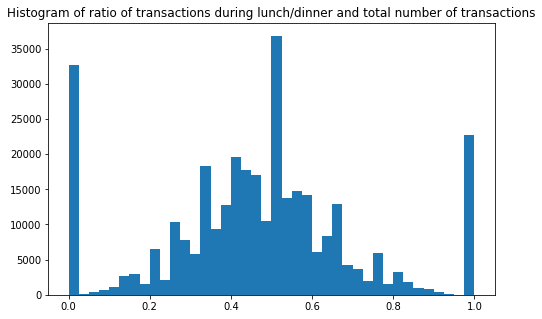

In [40]:
plt.figure(figsize=(8, 5))
plt_ret = plt.hist(df_n_trans['ratio_range'], bins=40)
plt.title('Histogram of ratio of transactions during lunch/dinner and total number of transactions')
plt.show()

The shape of this plot is a bit unexpected, so let's try to understand it. <br> 
The merchants corresponding with the right bar might be restaurants, but there could be more restaurants in the middle part. For instance the ones correspongind to the high bar at 0.5, which might correspond to coffe shops which open during the morning. However let's take a close look to these three bars to try to explain this extrange behavior.

In [61]:
bins = plt_ret[1]
df_left_bar = df_n_trans[df_n_trans['ratio_range']<=bins[0]]
df_right_bar = df_n_trans[df_n_trans['ratio_range']>=bins[len(bins)-2]]
df_middle_bar = df_n_trans[(df_n_trans['ratio_range']>=bins[round(len(bins)/2.0)]) & (df_n_trans['ratio_range']<=bins[round(len(bins)/2.0)+1])]

If the number of transactions is very few, it could be that they got "all" the transactions in these ranges by chance. For instance, 27033 merchants have exactly a rate of 0.5 out of the 37001 merchants in the middle bar. Then it is more likley that they had only a couple of transaction than they were coffe shops.

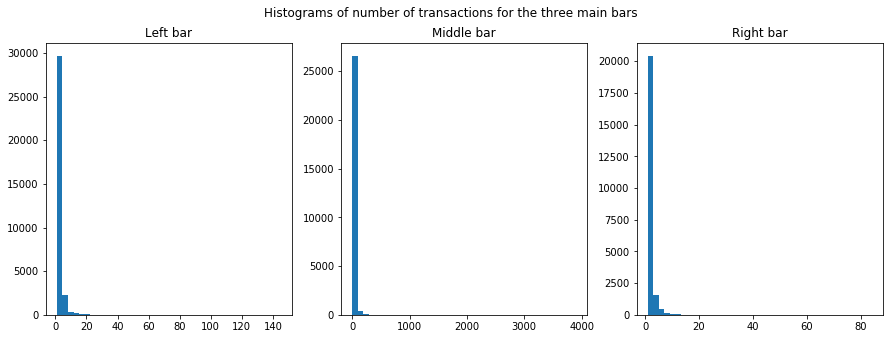

In [70]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(df_left_bar['n_trans'], bins=40)
plt.title('Left bar')
plt.subplot(1, 3, 2)
plt.hist(df_middle_bar['n_trans'], bins=40)
plt.title('Middle bar')
plt.subplot(1, 3, 3)
plt.hist(df_right_bar['n_trans'], bins=40)
plt.title('Right bar')
plt.suptitle('Histograms of number of transactions for the three main bars')
plt.show()

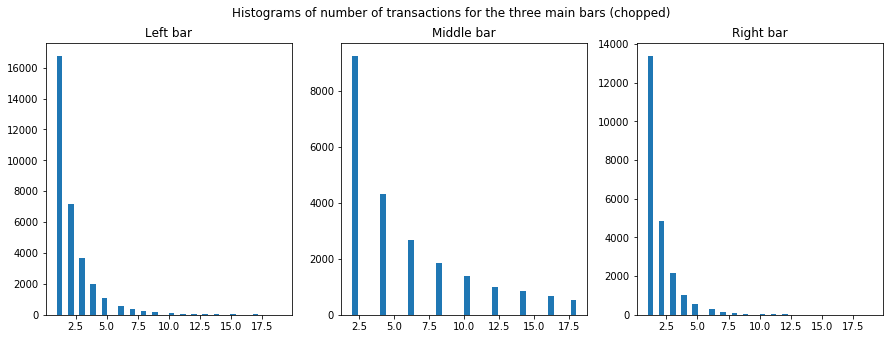

In [71]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(df_left_bar[df_left_bar['n_trans']<20]['n_trans'], bins=40)
plt.title('Left bar')
plt.subplot(1, 3, 2)
plt.hist(df_middle_bar[df_middle_bar['n_trans']<20]['n_trans'], bins=40)
plt.title('Middle bar')
plt.subplot(1, 3, 3)
plt.hist(df_right_bar[df_right_bar['n_trans']<20]['n_trans'], bins=40)
plt.title('Right bar')
plt.suptitle('Histograms of number of transactions for the three main bars (chopped)')
plt.show()

Indeed we see that most of the merchants in these three groups have a very few amount of transactions (most of them have only one), specially taking into account that the median number of transactions available per merchant is 15.

Let's see how the histogram of the ratios looks like if we remove the merchants with less than 10 transactions.

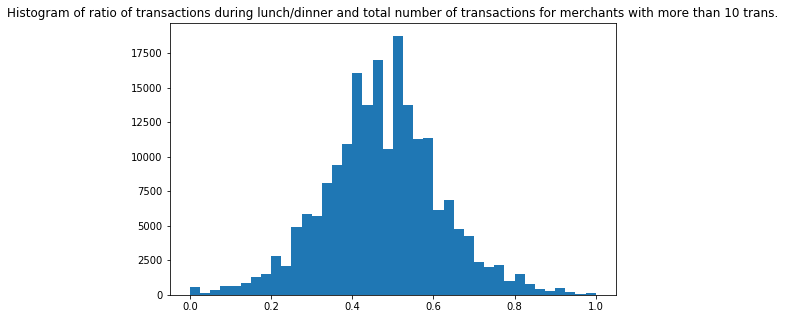

In [76]:
plt.figure(figsize=(8, 5))
plt_ret = plt.hist(df_n_trans[df_n_trans['n_trans']>=10]['ratio_range'], bins=40)
plt.title('Histogram of ratio of transactions during lunch/dinner and total number of transactions for merchants with more than 10 trans.')
plt.show()

We see that we've gotten rid of the bars at the extremes, but we are still not able to identify restaurants. Or maybe there  are not a lot of restaurants in the merchants set. If the group of restaurants was relevant, one would expect to have a local maximum at the right part of the histogram. However, it do seem to be a little bump around 0.8.

Let's check if the merchants with a high ratio (larger than 0.7) share group, category or subsector.

In [146]:
ids = df_n_trans[df_n_trans['ratio_range']>=0.7]['merchant_id'].values
df_merch[df_merch['merchant_id'].isin(ids)][['merchant_group_id', 'merchant_category_id', 'subsector_id']].head(15)

,merchant_group_id,merchant_category_id,subsector_id
5,20201,87,27
7,16430,529,20
16,9514,2,20
18,21536,278,37
20,577,497,27
26,35,781,7
29,4274,278,37
30,3303,360,34
35,33916,332,2
36,18976,80,37


In this small sample of merchants with higher ratio it only seems to be repeated values for the subsector column. However, let's count the number of different values for each one individually.

In [147]:
df_merch[df_merch['merchant_id'].isin(ids)][['merchant_group_id', 'merchant_category_id', 'subsector_id']].nunique()

merchant_group_id       23830
merchant_category_id      288
subsector_id               40
dtype: int64

There are 44475 merchants in this set of "possible restaurants", so the group_id initially doesn't seem to be very helpful. Neither the other ones, since there are 331 possible values for the merchant_category_id and 41 for the subsector_id. However, maybe we were not very lucky and the set of "possible restaurants" is too large, including a representative of each kind. So let's check the number of repetitions of each possible value. 

In [148]:
df_merch[df_merch['merchant_id'].isin(ids)].groupby('merchant_group_id').size().reset_index().rename(columns={0:'n_groups'}).sort_values('n_groups', ascending=False).head(3)

,merchant_group_id,n_groups
16,35,5153
234,434,64
1374,2808,59


In [149]:
df_merch[df_merch['merchant_id'].isin(ids)].groupby('merchant_category_id').size().reset_index().rename(columns={0:'n_categories'}).sort_values('n_categories', ascending=False).head(3)

,merchant_category_id,n_categories
84,278,5174
236,705,2571
22,68,2503


In [150]:
df_merch[df_merch['merchant_id'].isin(ids)].groupby('subsector_id').size().reset_index().rename(columns={0:'n_subsectors'}).sort_values('n_subsectors', ascending=False).head(3)

,subsector_id,n_subsectors
26,27,8408
35,37,8239
27,29,2809


So it seems that the merchant_group_id 35 might denote the restaurants, due to the big difference of occurrences compared with the second possition. 

To check this statement we have plotted again the histograms of the ratio of transactions in the lunch/dinner ranges for different combinations of the top values of each feature. The merchant_group_id 35 by itself is not very useful, but the histogram for category 278 shifts to the right. With a combination of these two we get the following histogram.

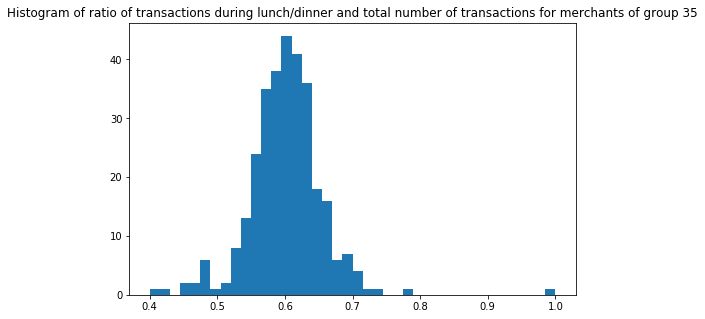

In [145]:
ids_rest = df_merch[(df_merch['merchant_category_id']==278) & (df_merch['merchant_group_id']==35)]['merchant_id'].values
plt.figure(figsize=(8, 5))
plt_ret = plt.hist(df_n_trans[df_n_trans['merchant_id'].isin(ids_rest)]['ratio_range'], bins=40)
plt.title('Histogram of ratio of transactions during lunch/dinner and total number of transactions for merchants of group 35')
plt.show()

Then, the group_id 35 might denote the hostelry merchants in general, and the category_id 278 might denote specifically the restaurants. Then, **the tuple (group_id, category_id) (35, 278)** seems to be the most promesing to identify restaurants.

Just to be sure, lets check the distribution of their mean number of transactions each hour.

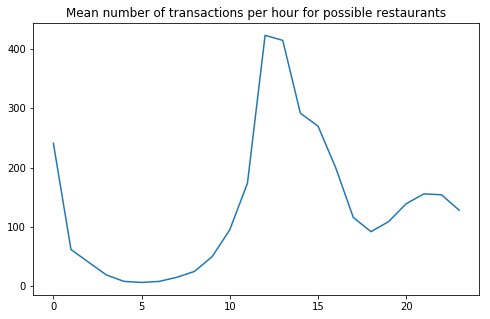

In [132]:
plt.figure(figsize=(8, 5))
plt.plot(df_trans[df_trans['merchant_id'].isin(ids_rest)].groupby('purchase_hour').size()/len(np.unique(ids_rest)))
plt.title("Mean number of transactions per hour for possible restaurants")
plt.show()

It looks quite similar to which one would expect for restaurants. Besides (as noticed by Zoltan), Brazil has two main different time zones, which could correspond to the "kind of" mixture shape that we see at the maximum.

So, let's answer the question that we posed at the beginning:

In [137]:
print("Percentage of merchants identified as possible restaurants: {:.2f}%".format(len(ids_rest)/df_merch.shape[0]*100))

Percentage of merchants identified as possible restaurants: 0.09%


Although this proportion seems too small to include all the restaurants, it might be safe to say that restaurants are not a significant group in the merchants set.